#STEP-1: IMPORTS AND LOADING THE IMAGE

In [ ]:
!pip install imageio matplotlib numpy scikit-image scikit-learn ipywidgets tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.4 MB/s eta 0:00:00


(1024, 1025, 3)


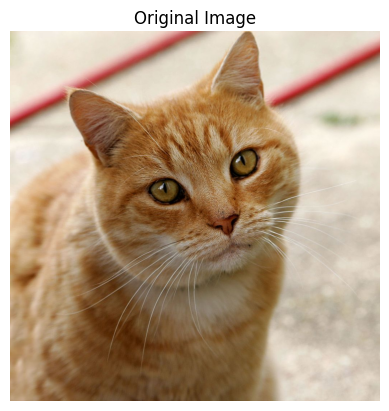

In [ ]:
import imageio.v3 as iio #pip install imageio (full documentation: https://imageio.readthedocs.io/en/stable/user_guide/installation.html)
import matplotlib.pyplot as plt
import numpy as np

# Loading the image + converting it into a numpy array of the form height * width * number of colour layers (channels)
image = iio.imread('/content/Cat.jpg') # Note: Save the image in the same folder as the script or give the full location
print(image.shape)

# Checking if the image was loaded properly
plt.imshow(image)
plt.axis('off') #to hide the axis ticks
plt.title('Original Image')
plt.show()

# STEP-2: NOISE FUNCTIONS

In [ ]:

def add_gaussian_noise(image, sigma = 25): # Noise function is defined taking two inputs: image as a numpy array and noise sigma which is 25 by default
	noisy = image.astype(np.float32) + np.random.normal(0, sigma, image.shape) # noisy image = original image converted to 32-bit float for math temporarily + noise array with values picked from normal distibution (mean = 0, SD = sigma, shape = same as original)
	return np.clip(noisy, 0, 255).astype(np.uint8) #converting back to valid 8-bit values (for visualization and storage purposes)

def add_salt_pepper_noise(image, alpha = 0.05):
	noisy = image.copy() #since this messes with the image directly unlike Gaussian noise, a copy is created to avoid corrupting the original image
	h, w, c = image.shape #to get the image dimensions: height, width, number of channels
	num_pixels = int(alpha*h*w) #number/proportion of pixels to corrupt (based on alpha)

	#Adding salt (255)
	for step in range(num_pixels): #loop for each pixel to corrupt
		i = np.random.randint(0,h) #randomly pick a row/height
		j = np.random.randint(0, w) #randomly pick a width
		noisy[i,j] = [255]*c #setting all channels (RGB) at this pixel to 255

	#Adding pepper (0)
	for step in range(num_pixels):
		i = np.random.randint(0,h)
		j = np.random.randint(0, w)
		noisy[i,j] = [0]*c #setting all channels (RGB) at this pixel to 0

	return noisy


# STEP-3: USER SELECTS THE TYPE OF NOISE AND ITS INTENSITY

Which type of noise do you want to add to the image: gaussian/salt_pepper)?gaussian
How strong is the Gaussian noise you want to add? (enter a number between 0 and 100): 80


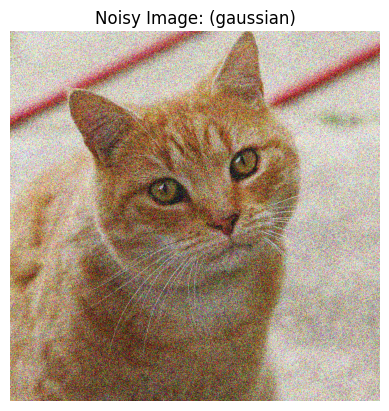

In [ ]:
# Noise Type
noise_type = input("Which type of noise do you want to add to the image: gaussian/salt_pepper)?").strip().lower()

# Noise Intensity
if noise_type == "gaussian":
  while True:
    try:
      sigma = float(input("How strong is the Gaussian noise you want to add? (enter a number between 0 and 100): "))
      if 0 <= sigma <= 100:
              break
      print("Please enter a value between 0 and 100.")
    except ValueError:
      print("Invalid input. Enter a number.")
  noisy_image = add_gaussian_noise(image, sigma = sigma)

  # Displaying the noisy image
  plt.imshow(noisy_image)
  plt.axis('off')
  plt.title(f'Noisy Image: ({noise_type})')
  plt.show()

elif noise_type == "salt_pepper":
  while True:
    try:
      alpha = float(input("What proportion of pixels do you want to corrupt? (enter a number between 0 and 1):"))
      if 0 <= alpha <= 1:
                break
      print("Please enter a value between 0 and 1.")
    except ValueError:
      print("Invalid input. Enter a number.")

  noisy_image = add_salt_pepper_noise(image, alpha = alpha)

  # Displaying the noisy image
  plt.imshow(noisy_image)
  plt.axis('off')
  plt.title(f'Noisy Image: ({noise_type})')
  plt.show()


# STEP-4: THE DENOISING ENGINE

In [ ]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.util import img_as_float, img_as_ubyte

# Non-Local Means (for each pixel, it averages the intensity of similar patches elsewhere in the image)
def denoise_non_local_means(noisy_image):
	image_float = img_as_float(noisy_image) #convert to float ranging between 0 and 1 so that its compatible with skimage
	sigma_est = np.mean(estimate_sigma(image_float, channel_axis = -1)) #estimates the sigma of the noise per channel
	# Core Denoising
	denoised = denoise_nl_means(
		image_float,
		h = 1.15*sigma_est, #Filter strength
		fast_mode = True, #Faster but less accurate version
		patch_size = 5, #Size of the patches
		patch_distance = 6, #How far to extend the search for similar patches
		channel_axis = -1 #Preserves RGB channels
	)
	#Convert to 8-bit for display
	return img_as_ubyte(denoised)


# Principal Component Analysis (similar patches are decomposed into their principal components and separates noise from signal on a patch by patch basis.)
from sklearn.decomposition import PCA
from tqdm import tqdm  # for progress bar

def denoise_pca_patches(noisy_image, patch_size=7, n_similar=30, n_components=10):
    """
    Patch-based PCA denoising for RGB noisy images.

    Arguments:
        noisy_image: noisy RGB image as numpy array (H x W x 3)
        patch_size: size of patches (default 7, must be odd)
        n_similar: number of similar patches for PCA grouping (default 30)
        n_components: number of PCA components to keep (default 10)

    Returns:
        denoised RGB image as uint8 numpy array
    """
    if patch_size % 2 == 0:
        raise ValueError("Patch size must be odd")

    H, W, C = noisy_image.shape
    assert C == 3, "Input must be an RGB image"

    image = noisy_image.astype(np.float32)
    pad = patch_size // 2
    padded = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='reflect')

    # Extract all patches
    patches = np.zeros((H*W, patch_size, patch_size, C))
    for i in range(H):
        for j in range(W):
            patches[i*W + j] = padded[i:i+patch_size, j:j+patch_size, :]
    patches_flat = patches.reshape(len(patches), -1)  # flatten patches

    # Prepare output
    image_denoised = np.zeros_like(padded, dtype=np.float32)
    weight_sum = np.zeros_like(padded, dtype=np.float32)

    # Process each patch
    for idx in tqdm(range(len(patches_flat)), desc="Denoising"):
        ref_patch = patches_flat[idx]

        # Find similar patches
        distances = np.linalg.norm(patches_flat - ref_patch, axis=1)
        similar_idx = np.argpartition(distances, n_similar)[:n_similar]
        group = patches_flat[similar_idx]

        # Apply PCA
        pca = PCA(n_components=min(n_components, n_similar-1), svd_solver='randomized')
        pca.fit(group)
        projected = pca.transform(group)
        reconstructed = pca.inverse_transform(projected)

        # Get denoised version of the reference patch
        denoised_patch = reconstructed[0].reshape(patch_size, patch_size, C)

        # Accumulate to output
        i, j = idx // W, idx % W
        image_denoised[i:i+patch_size, j:j+patch_size, :] += denoised_patch
        weight_sum[i:i+patch_size, j:j+patch_size, :] += 1

    # Normalize and clip
    eps = 1e-8
    denoised = image_denoised[pad:-pad, pad:-pad, :] / (weight_sum[pad:-pad, pad:-pad, :] + eps)
    denoised = np.clip(denoised, 0, 255).astype(np.uint8)

    return denoised

# STEP-5: USER SELECTS THE TYPE OF DENOISING

In [ ]:

# Denoising Method
denoise_type = input("Which denoising method do you want to use? (non_local_means / pca): ").strip().lower()

if denoise_type == "non_local_means":
    denoised_image = denoise_non_local_means(noisy_image)
elif denoise_type == "pca":
    # Let user change PCA settings
    try:
        patch_size = int(input("Patch size (odd number, e.g., 7): "))
        n_similar = int(input("Number of similar patches to use (e.g., 30): "))
        n_components = int(input("Number of PCA components to retain (e.g., 10): "))
    except ValueError:
        print("Invalid input, using default parameters (patch_size=7, n_similar=30, n_components=10).")
        patch_size, n_similar, n_components = 7, 30, 10

    denoised_image = denoise_pca_patches(
        noisy_image,
        patch_size=patch_size,
        n_similar=n_similar,
        n_components=n_components
    )
else:
    print("Invalid denoising method selected. Showing noisy image as is.")
    denoised_image = noisy_image


Which denoising method do you want to use? (non_local_means / pca): non_local_means


# STEP-6: DENOISING PERFORMANCE

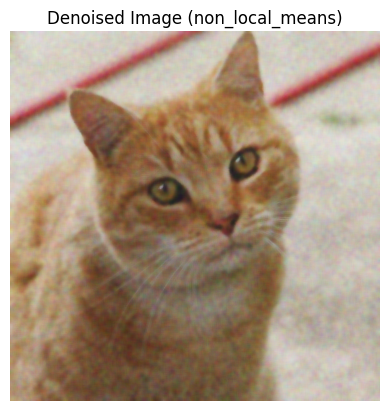

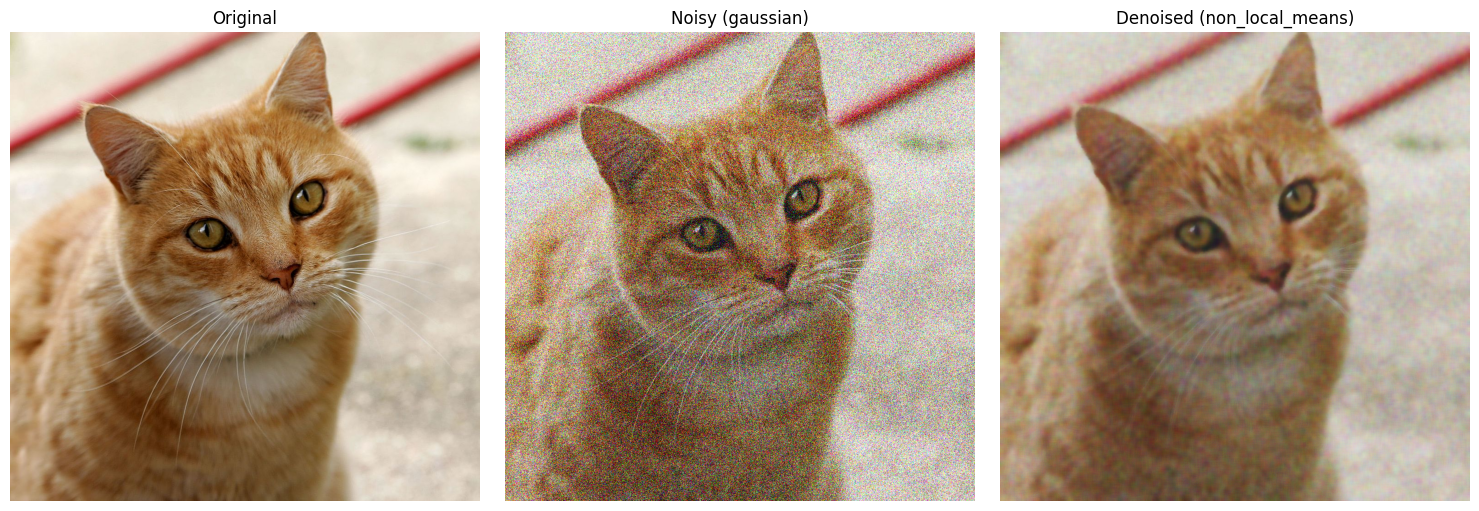

Structural Similarity Index (SSIM) between original and denoised image: 0.7161
Peak Signal to Noise Ratio: 24.30 dB


In [ ]:

# 6.1 - Qualitative Comparison [Visual]

# Showing the denoised image
plt.imshow(denoised_image)
plt.axis('off')
plt.title(f"Denoised Image ({denoise_type})")
plt.show()

# Side-by-side comparison - Original vs Noisy vs Denoised
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[0].axis('off')

axs[1].imshow(noisy_image)
axs[1].set_title(f"Noisy ({noise_type})")
axs[1].axis('off')

axs[2].imshow(denoised_image)
axs[2].set_title(f"Denoised ({denoise_type})")
axs[2].axis('off')

plt.tight_layout()
plt.show()

# 6.2 - Quantitative Comparison [SSIM, PSNR]

# 6.2.1 - Structural Similarity Index (SSIM)
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(original, denoised):
    if original.ndim == 3 and original.shape[2] == 3:
        ssim_values = []
        for i in range(3):  # Compute SSIM separately for R, G, B
            s = ssim(original[:, :, i], denoised[:, :, i], data_range=255)
            ssim_values.append(s)
        return np.mean(ssim_values)
    else:
        return ssim(original, denoised, data_range=255)

# Compute SSIM
ssim_score = calculate_ssim(image, denoised_image)
print(f"Structural Similarity Index (SSIM) between original and denoised image: {ssim_score:.4f}")

# 6.2.2 - Peak SNR (PSNR)
from skimage.metrics import peak_signal_noise_ratio as psnr
psnr_score = psnr(image, denoised_image, data_range=255)
print(f"Peak Signal to Noise Ratio: {psnr_score:.2f} dB")

################################################################# FIN #################################################################